In [40]:
import numpy as np
import pandas as pd
import torch

import re
import os
from os.path import join, dirname, basename
from tqdm import tqdm
from glob import glob

import nibabel as nib

import matplotlib.pyplot as plt

In [2]:
def sub2adni(sub):
    return 'sub-ADNI'+''.join(sub.split('_'))
def df2path(df, i):
    return join('saliency_map', df.split.iloc[i], df.participant_id.iloc[i], df.session_id.iloc[i]+'.npy')
def path2subsess(path):
    sub = re.search(r'sub-[a-zA-Z0-9]{1,}', path).group(0)
    sess = re.search(r'ses-M[0-9]{1,}', path).group(0)
    return sub, sess
def subsess2path(sub, sess):
    return join('ADNI_CAPS', 'subjects', sub, sess, 'deeplearning_prepare_data', 'image_based', 't1_linear',\
               sub+'_'+sess+'_'+'T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_T1w.pt')
def imgfromsubsess(sub, sess):
    return torch.load(subsess2path(sub, sess)).squeeze(0).numpy()

In [3]:
subs = glob('ADNI_CAPS/subjects/*')

In [4]:
subs[:5]

['ADNI_CAPS/subjects/sub-ADNI094S0711',
 'ADNI_CAPS/subjects/sub-ADNI007S0068',
 'ADNI_CAPS/subjects/sub-ADNI114S1118',
 'ADNI_CAPS/subjects/sub-ADNI018S0450',
 'ADNI_CAPS/subjects/sub-ADNI067S1185']

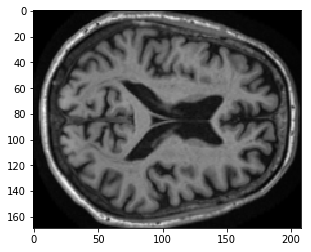

In [5]:
ex = imgfromsubsess('sub-ADNI094S0711', 'ses-M00')
plt.imshow(ex[:,:,90], cmap='gray')

In [6]:
snp_subs = np.loadtxt('SNP/samples.txt', dtype=str)
snp_subs = np.array(list(map(sub2adni, snp_subs)))

In [7]:
df = pd.read_csv('ADNI_CAPS/split.stratified.0.csv')
tmp = df[df['participant_id'].isin(snp_subs)]
tmp = tmp.sort_values(by=['session_id'], ascending=False)
tmp = tmp.drop_duplicates(subset=['participant_id'])
df_snp = tmp.reset_index(drop=True)

In [14]:
train_df = pd.read_csv('saliency_map/train_sailency_info.csv')
test_df = pd.read_csv('saliency_map/test_sailency_info.csv')
val_df = pd.read_csv('saliency_map/val_sailency_info.csv')
df_pred = pd.concat([train_df, test_df, val_df])
df_pred = df_pred.reset_index(drop=True)

In [16]:
df_snp = df_snp.merge(df_pred, how='inner', on=['participant_id', 'session_id'])
df_snp['diagnosis_pred'] = df_snp['prob_AD'].map(lambda x: np.round(x))
snp_correct = df_snp['diagnosis_y'] == df_snp['diagnosis_pred'].map(lambda x: int(x))
df_snp_correct = df_snp[snp_correct]

In [27]:
snp_paths = [df2path(df_snp, i) for i in range(len(df_snp))]
snp_labels = df_snp.diagnosis_x.values
snp_correct_paths = [df2path(df_snp_correct, i) for i in range(len(df_snp_correct))]
snp_correct_labels = df_snp_correct.diagnosis_x.values

In [10]:
def saliencyDraw(ax, ex_sal, saliency_cmap, saliency_alpha):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)

    ax_cb = divider.new_horizontal(size="5%", pad=0.05)
    fig = ax.get_figure()
    fig.add_axes(ax_cb)

    im = ax.imshow(ex_sal, cmap=saliency_cmap, alpha=saliency_alpha)

    plt.colorbar(im, cax=ax_cb)
    ax_cb.yaxis.tick_right()
    ax_cb.yaxis.set_tick_params(labelright=False)

In [35]:
def drawFromPath(path, label, save_dir='2d_view'):
    sub, sess = path2subsess(path)
    
    ex = imgfromsubsess(sub, sess)
    sagittal_idx, coronal_idx, axial_idx = [i//2 for i in ex.shape]
    view_cmap = 'gray'
    fig, axes = plt.subplots(ncols=3, figsize=(15,5))
    ax = axes.ravel()
    ax[0].imshow(ex[sagittal_idx, :, :], cmap=view_cmap)
    ax[1].imshow(ex[:, coronal_idx, :], cmap=view_cmap)
    ax[2].imshow(ex[:, :, axial_idx], cmap=view_cmap)
    ax[0].set_title('Sagittal view')
    ax[1].set_title('Coronal view')
    ax[2].set_title('Axial view')
    
    saliency_cmap = 'jet'
    saliency_alpha = 0.3
    ex_sal = np.load(path)
#     im1 = ax[0].imshow(ex_sal[sagittal_idx, :, :], cmap=saliency_cmap, alpha=saliency_alpha)
#     im2 = ax[1].imshow(ex_sal[:, coronal_idx, :], cmap=saliency_cmap, alpha=saliency_alpha)
#     im3 = ax[2].imshow(ex_sal[:, :, axial_idx], cmap=saliency_cmap, alpha=saliency_alpha)
    saliencyDraw(ax[0], ex_sal[sagittal_idx, :, :], saliency_cmap, saliency_alpha)
    saliencyDraw(ax[1], ex_sal[:, coronal_idx, :], saliency_cmap, saliency_alpha)
    saliencyDraw(ax[2], ex_sal[:, :, axial_idx], saliency_cmap, saliency_alpha)
    
    os.makedirs(save_dir, exist_ok=True)
    fig.savefig(join(save_dir, '_'.join([label, sub, sess, '2d_view.png'])))
    fig.clf()

In [33]:
i = 0
drawFromPath(snp_correct_paths[i], snp_correct_labels[i])

In [34]:
for p, l in tqdm(zip(snp_correct_paths, snp_correct_labels)):
    drawFromPath(p,l,'2d_view_correct')

20it [00:09,  2.17it/s]/home/student/anaconda3/envs/ad/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
195it [01:33,  2.04it/s]


In [23]:
df_snp_correct

,participant_id,session_id,age,sex,diagnosis_x,split,diagnosis_y,prob_AD,diagnosis_pred
0,sub-ADNI021S0337,ses-M96,75.8,Male,CN,train,0,0.119849,0.0
1,sub-ADNI099S0352,ses-M96,77.0,Female,CN,train,0,0.355188,0.0
2,sub-ADNI027S0074,ses-M96,78.2,Male,CN,train,0,0.250330,0.0
4,sub-ADNI035S0555,ses-M96,77.0,Male,MCI,val,1,0.655683,1.0
5,sub-ADNI023S0331,ses-M96,64.6,Female,AD,val,1,0.903480,1.0
...,...,...,...,...,...,...,...,...,...
218,sub-ADNI141S0697,ses-M18,86.8,Male,MCI,train,1,0.598037,1.0
219,sub-ADNI033S1116,ses-M18,83.4,Male,MCI,train,1,0.699803,1.0
220,sub-ADNI127S0684,ses-M12,77.4,Female,CN,test,0,0.323724,0.0
221,sub-ADNI128S0138,ses-M12,86.3,Male,MCI,train,1,0.674724,1.0


In [24]:
df_snp

,participant_id,session_id,age,sex,diagnosis_x,split,diagnosis_y,prob_AD,diagnosis_pred
0,sub-ADNI021S0337,ses-M96,75.8,Male,CN,train,0,0.119849,0.0
1,sub-ADNI099S0352,ses-M96,77.0,Female,CN,train,0,0.355188,0.0
2,sub-ADNI027S0074,ses-M96,78.2,Male,CN,train,0,0.250330,0.0
3,sub-ADNI005S0610,ses-M96,79.0,Male,CN,val,0,0.595378,1.0
4,sub-ADNI035S0555,ses-M96,77.0,Male,MCI,val,1,0.655683,1.0
...,...,...,...,...,...,...,...,...,...
219,sub-ADNI033S1116,ses-M18,83.4,Male,MCI,train,1,0.699803,1.0
220,sub-ADNI127S0684,ses-M12,77.4,Female,CN,test,0,0.323724,0.0
221,sub-ADNI128S0138,ses-M12,86.3,Male,MCI,train,1,0.674724,1.0
222,sub-ADNI011S0008,ses-M06,84.5,Female,CN,test,0,0.489837,0.0


In [44]:
img = nib.load('CIT168_gm_700um.nii.gz')
img = img.get_fdata()

In [45]:
img.shape

(198, 263, 212)

In [41]:
import ipyvolume as ipv

In [46]:
ipv.quickvolshow(img)

/home/student/anaconda3/envs/ad/lib/python3.6/site-packages/ipyvolume/widgets.py:179: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data_view = self.data_original[view]
/home/student/anaconda3/envs/ad/lib/python3.6/site-packages/ipyvolume/utils.py:204: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data = (data[slices1] + data[slices2])/2
/home/student/anaconda3/envs/ad/lib/python3.6/site-packages/ipyvolume/serialize.py:81: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0]**2 + gradient[1]

In [47]:
np.unique(img)

array([0.00000000e+00, 8.23123788e-18, 9.62992750e-18, ...,
       9.99998391e-01, 9.99998450e-01, 9.99998510e-01])